# AutoML

## Setting Up ML Client

In [1]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

# 🔐 Authenticate and connect to Azure ML workspace
credential = DefaultAzureCredential()
ml_client = MLClient.from_config(credential=credential)

# ✅ Confirm connection
print("\n✅ Azure ML Workspace Loaded Successfully\n")
print(f"🔑 Subscription ID : {ml_client.subscription_id}")
print(f"📦 Resource Group  : {ml_client.resource_group_name}")
print(f"🧠 Workspace Name  : {ml_client.workspace_name}\n")

Found the config file in: /config.json



✅ Azure ML Workspace Loaded Successfully

🔑 Subscription ID : 03571d3d-f675-492f-8346-8b04c78ed80f
📦 Resource Group  : student-performance-rg
🧠 Workspace Name  : student-performance-ws



## Grabbing the Name of the Storage Account

In [2]:
from azure.mgmt.storage import StorageManagementClient

subscription_id = ml_client.subscription_id  
resource_group = ml_client.resource_group_name

storage_client = StorageManagementClient(credential, subscription_id)

# List storage accounts in the resource group
accounts = list(storage_client.storage_accounts.list_by_resource_group(resource_group))

# Check if any accounts exist
if not accounts:
    raise Exception("❌ No storage accounts found in this resource group.")

# Grab the first one
storage_account_name = accounts[0].name

# ✅ Optional: print them
print("\n📦 Storage Accounts in Resource Group:")
for account in accounts:
    print("•", account.name)

print(f"\n✅ Using storage account named: {storage_account_name}")


📦 Storage Accounts in Resource Group:
• studperfstor

✅ Using storage account named: studperfstor


## Grabbing the Name of the Container with JSON Data

In [3]:
from azure.storage.blob import BlobServiceClient

# Get storage account keys
keys = storage_client.storage_accounts.list_keys(resource_group, storage_account_name)
storage_key = keys.keys[0].value

# Build BlobServiceClient using account name and key
account_url = f"https://{storage_account_name}.blob.core.windows.net"
blob_service_client = BlobServiceClient(account_url=account_url, credential=storage_key)

# List all containers and filter
print("\n📁 Blob Containers in the Storage Account (filtered):")
filtered_containers = [
    container.name for container in blob_service_client.list_containers()
    if "insights" not in container.name.lower() and "azureml" not in container.name.lower()
]

if not filtered_containers:
    raise Exception("❌ No user-defined containers found (filtered out 'insights' and 'azureml').")

# Grab the first matching container
container_name = filtered_containers[0]

# ✅ Output
for name in filtered_containers:
    print("•", name)

print(f"\n✅ Using container: {container_name}")


📁 Blob Containers in the Storage Account (filtered):
• student-math-project-files

✅ Using container: student-math-project-files


## Locating the Name of the Config File

In [4]:
# Create a ContainerClient for the chosen container
container_client = blob_service_client.get_container_client(container_name)

# Find the first .json blob in the container
config_name = None
print(f"\n📄 Files in Container '{container_name}':")

for blob in container_client.list_blobs():
    print("•", blob.name)
    if config_name is None and blob.name.lower().endswith(".json"):
        config_name = blob.name

if not config_name:
    raise Exception("❌ No .json file found in this container.")

print(f"\n✅ Using config file: {config_name}")


📄 Files in Container 'student-math-project-files':
• config.json
• student-mat.csv

✅ Using config file: config.json


## Importing Config Information and Saving It In Memory

In [5]:
import json
from azure.storage.blob import BlobClient

# === Build blob URL and load JSON ===
blob_url = f"https://{storage_account_name}.blob.core.windows.net/{container_name}/{config_name}"
blob_client = BlobClient.from_blob_url(blob_url, credential=credential)

# Download and parse JSON
json_bytes = blob_client.download_blob().readall()
json_data = json.loads(json_bytes)

# === Metadata ===
created_at = json_data["metadata"]["created_at"]
created_year = json_data["metadata"]["created_year"]
created_month = json_data["metadata"]["created_month"]
created_day = json_data["metadata"]["created_day"]
created_time = json_data["metadata"]["created_time"]

# === Azure Info ===
subscription_id = json_data["azure"]["subscription_id"]
resource_group = json_data["azure"]["resource_group"]
location = json_data["azure"]["location"]
storage_account_name = json_data["azure"]["storage_account_name"]
storage_container_uri = json_data["azure"]["storage_container_uri"]
managed_identity_principal_id = json_data["azure"]["managed_identity_principal_id"]
auth_mode = json_data["azure"]["auth_mode"]

# === Workspace Info ===
workspace_name = json_data["workspace"]["workspace_name"]
storage_account_id = json_data["workspace"]["storage_account_id"]
key_vault_id = json_data["workspace"]["key_vault_id"]
app_insights_id = json_data["workspace"]["application_insights_id"]

# === Datastore Info ===
datastore_name = json_data["datastore"]["datastore_name"]
container_name = json_data["datastore"]["container_name"]
blob_name = json_data["datastore"]["blob_name"]

# === Dataset Info ===
dataset_name = json_data["dataset"]["dataset_name"]
dataset_uri = json_data["dataset"]["dataset_uri"]
dataset_version = json_data["dataset"]["dataset_version"]
dataset_description = json_data["dataset"]["dataset_description"]
delimiter = json_data["dataset"]["delimiter"]
encoding = json_data["dataset"]["encoding"]
has_header = json_data["dataset"]["has_header"]

# === Compute Info ===
compute_name = json_data["compute"]["compute_name"]
compute_size = json_data["compute"]["compute_size"]

# === Pretty Print with Emojis ===
print("\n📅 Workspace Metadata:")
print(f"  • Created At   : {created_at}")
print(f"  • Date         : {created_day} {created_month} {created_year}")
print(f"  • Time         : {created_time}")

print("\n🔐 Azure Configuration:")
print(f"  • Subscription ID      : {subscription_id}")
print(f"  • Resource Group       : {resource_group}")
print(f"  • Location             : {location}")
print(f"  • Auth Mode            : {auth_mode}")
print(f"  • Managed Identity ID  : {managed_identity_principal_id}")

print("\n📦 Storage:")
print(f"  • Account Name         : {storage_account_name}")
print(f"  • Container URI        : {storage_container_uri}")

print("\n🧠 Workspace:")
print(f"  • Workspace Name       : {workspace_name}")
print(f"  • Storage Account ID   : {storage_account_id}")
print(f"  • Key Vault ID         : {key_vault_id}")
print(f"  • App Insights ID      : {app_insights_id}")

print("\n🗃️ Datastore:")
print(f"  • Datastore Name       : {datastore_name}")
print(f"  • Container Name       : {container_name}")
print(f"  • Blob Name            : {blob_name}")

print("\n📊 Dataset:")
print(f"  • Dataset Name         : {dataset_name}")
print(f"  • Version              : {dataset_version}")
print(f"  • Description          : {dataset_description}")
print(f"  • URI                  : {dataset_uri}")
print(f"  • Delimiter            : {delimiter}")
print(f"  • Encoding             : {encoding}")
print(f"  • Has Header           : {has_header}")

print("\n🖥️ Compute:")
print(f"  • Compute Name         : {compute_name}")
print(f"  • Compute Size         : {compute_size}\n")


📅 Workspace Metadata:
  • Created At   : 2025-04-16T15:36:33+0200
  • Date         : 16 April 2025
  • Time         : 15:36:33 CEST

🔐 Azure Configuration:
  • Subscription ID      : 03571d3d-f675-492f-8346-8b04c78ed80f
  • Resource Group       : student-performance-rg
  • Location             : norwayeast
  • Auth Mode            : managed_identity
  • Managed Identity ID  : a4d92aeb-6282-4e38-8fbb-69806440a455

📦 Storage:
  • Account Name         : studperfstor
  • Container URI        : https://studperfstor.blob.core.windows.net/student-math-project-files

🧠 Workspace:
  • Workspace Name       : student-performance-ws
  • Storage Account ID   : /subscriptions/03571d3d-f675-492f-8346-8b04c78ed80f/resourceGroups/student-performance-rg/providers/Microsoft.Storage/storageAccounts/studperfstor
  • Key Vault ID         : /subscriptions/03571d3d-f675-492f-8346-8b04c78ed80f/resourceGroups/student-performance-rg/providers/Microsoft.KeyVault/vaults/studentpkeyvault
  • App Insights ID      :

## Importing the Dataset

In [29]:
import pandas as pd
from tabulate import tabulate

print(f"\n📦 Fetching dataset '{dataset_name}' (v{dataset_version})...")

try:
    # SDK v2 style: directly fetch the dataset by name & version
    dataset = ml_client.data.get(name=dataset_name, version=dataset_version)

    if not dataset.path:
        print("❌ No accessible path found in data asset.")
    else:
        print(f"📄 Path: {dataset.path}")
        df = pd.read_csv(dataset.path, delimiter=delimiter, encoding=encoding)

        # Drop 2nd and 3rd last columns
        cols_to_drop = df.columns[-3:-1]
        df.drop(columns=cols_to_drop, inplace=True)

        print("✅ Dataset loaded successfully!")
        print(tabulate(df.head(), headers='keys', tablefmt='fancy_grid'))   
except Exception as e:
    print("❌ Failed to load dataset with pandas.")
    print("Error:", e)


📦 Fetching dataset 'student-math' (v1)...
📄 Path: azureml://subscriptions/03571d3d-f675-492f-8346-8b04c78ed80f/resourcegroups/student-performance-rg/workspaces/student-performance-ws/datastores/studentmathdatastore/paths/student-mat.csv
✅ Dataset loaded successfully!
╒════╤══════════╤═══════╤═══════╤═══════════╤═══════════╤═══════════╤════════╤════════╤═════════╤══════════╤══════════╤════════════╤══════════════╤═════════════╤════════════╤═════════════╤══════════╤════════╤══════════════╤═══════════╤══════════╤════════════╤════════════╤══════════╤════════════╤═════════╤════════╤════════╤══════════╤════════════╤══════╕
│    │ school   │ sex   │   age │ address   │ famsize   │ Pstatus   │   Medu │   Fedu │ Mjob    │ Fjob     │ reason   │ guardian   │   traveltime │   studytime │   failures │ schoolsup   │ famsup   │ paid   │ activities   │ nursery   │ higher   │ internet   │ romantic   │   famrel │   freetime │   goout │   Dalc │   Walc │   health │   absences │   G3 │
╞════╪══════════╪══

## Creating Summary Statistics on the Dataset

In [30]:
from tabulate import tabulate

# Transpose so stats are rows, not columns (optional, for better layout)
summary = df.describe().transpose()

# Print with headers and index
print(tabulate(summary, headers="keys", tablefmt="fancy_grid", showindex=True))

╒════════════╤═════════╤═══════════╤══════════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│            │   count │      mean │      std │   min │   25% │   50% │   75% │   max │
╞════════════╪═════════╪═══════════╪══════════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ age        │     395 │ 16.6962   │ 1.27604  │    15 │    16 │    17 │    18 │    22 │
├────────────┼─────────┼───────────┼──────────┼───────┼───────┼───────┼───────┼───────┤
│ Medu       │     395 │  2.74937  │ 1.09474  │     0 │     2 │     3 │     4 │     4 │
├────────────┼─────────┼───────────┼──────────┼───────┼───────┼───────┼───────┼───────┤
│ Fedu       │     395 │  2.52152  │ 1.0882   │     0 │     2 │     2 │     3 │     4 │
├────────────┼─────────┼───────────┼──────────┼───────┼───────┼───────┼───────┼───────┤
│ traveltime │     395 │  1.4481   │ 0.697505 │     1 │     1 │     1 │     2 │     4 │
├────────────┼─────────┼───────────┼──────────┼───────┼───────┼───────┼───────┼───────┤
│ studytime  │     395 │  2.0354

## Distribution of G3 Scores

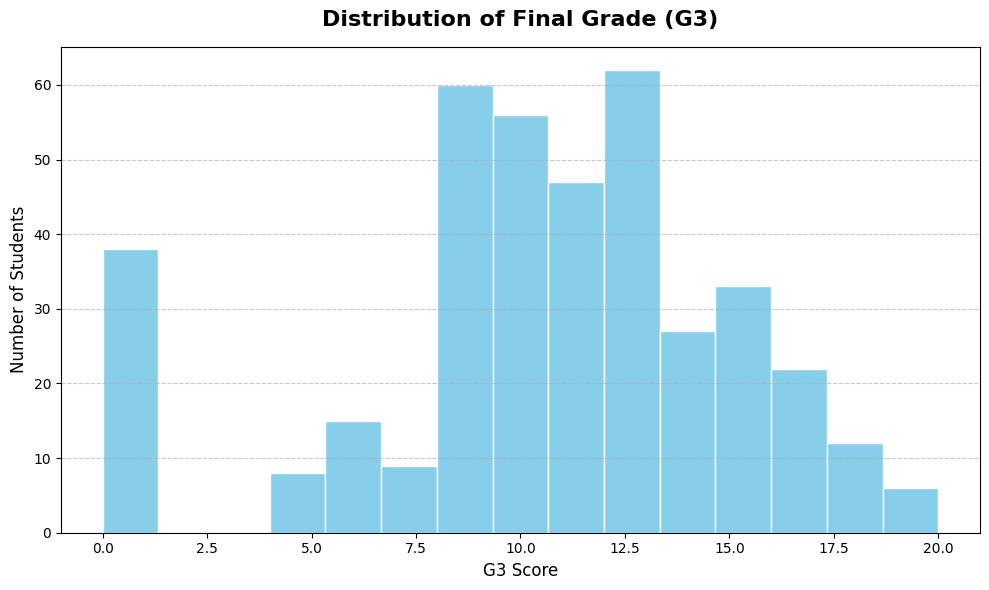


📊 Summary Statistics for G3 (Final Grade):

- Mean:                  10.42
- Median:                11.0
- Mode(s):               10
- Standard Deviation:    4.58
- Min:                   0
- Max:                   20

📐 Distribution Shape:
- Skewness:              -0.730  (Left-skewed)
- Kurtosis:              +0.383  (Leptokurtic)

📈 Percentiles:
- 10th               5.0
- 25th (Q1)          8.0
- 50th (Median)      11.0
- 75th (Q3)          14.0
- 90th               15.600000000000023

📊 Performance Breakdown:
- Above average:         209 students
- Below average:         186 students
- Failing (≤ 9):      130
- Perfect score (20):    1

🚨 Outliers detected:     0 student(s) using IQR method


In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# ╔════════════════════════════════════════════════════════════╗
# ║                     🎨 G3 HISTOGRAM PLOT                   ║
# ╚════════════════════════════════════════════════════════════╝

plt.figure(figsize=(10, 6))  # Wider plot

# Plot histogram
plt.hist(df["G3"], bins=15, edgecolor='white', color='skyblue')

# Titles and labels
plt.title("Distribution of Final Grade (G3)", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("G3 Score", fontsize=12)
plt.ylabel("Number of Students", fontsize=12)

# Grid & ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Tight layout for spacing
plt.tight_layout()
plt.show()

# ╔════════════════════════════════════════════════════════════╗
# ║         📊 STATISTICAL SUMMARY OF G3 DISTRIBUTION          ║
# ╚════════════════════════════════════════════════════════════╝

# Extract G3 column
g3 = df["G3"]

# Basic stats
mean = g3.mean()
median = g3.median()
mode = g3.mode().values
std = g3.std()
min_val = g3.min()
max_val = g3.max()

# Distribution shape
skewness = stats.skew(g3)
kurtosis = stats.kurtosis(g3)

# Percentiles
percentiles = {
    "10th": np.percentile(g3, 10),
    "25th (Q1)": np.percentile(g3, 25),
    "50th (Median)": np.percentile(g3, 50),
    "75th (Q3)": np.percentile(g3, 75),
    "90th": np.percentile(g3, 90),
}

# Counts relative to mean
above_avg = (g3 > mean).sum()
below_avg = (g3 < mean).sum()

# Thresholds
fail_threshold = 9
perfect_score = 20
num_failing = (g3 <= fail_threshold).sum()
num_perfect = (g3 == perfect_score).sum()

# Outlier detection using IQR
Q1 = percentiles["25th (Q1)"]
Q3 = percentiles["75th (Q3)"]
IQR = Q3 - Q1
outliers = g3[(g3 < (Q1 - 1.5 * IQR)) | (g3 > (Q3 + 1.5 * IQR))]

# Display everything
print("\n📊 Summary Statistics for G3 (Final Grade):\n")
print(f"- Mean:                  {mean:.2f}")
print(f"- Median:                {median}")
print(f"- Mode(s):               {', '.join(map(str, mode))}")
print(f"- Standard Deviation:    {std:.2f}")
print(f"- Min:                   {min_val}")
print(f"- Max:                   {max_val}")

print("\n📐 Distribution Shape:")
print(f"- Skewness:              {skewness:+.3f}  ({'Right-skewed' if skewness > 0 else 'Left-skewed' if skewness < 0 else 'Symmetrical'})")
print(f"- Kurtosis:              {kurtosis:+.3f}  ({'Leptokurtic' if kurtosis > 0 else 'Platykurtic' if kurtosis < 0 else 'Mesokurtic'})")

print("\n📈 Percentiles:")
for label, value in percentiles.items():
    print(f"- {label:<18} {value}")

print("\n📊 Performance Breakdown:")
print(f"- Above average:         {above_avg} students")
print(f"- Below average:         {below_avg} students")
print(f"- Failing (≤ {fail_threshold}):      {num_failing}")
print(f"- Perfect score ({perfect_score}):    {num_perfect}")

print(f"\n🚨 Outliers detected:     {len(outliers)} student(s) using IQR method")

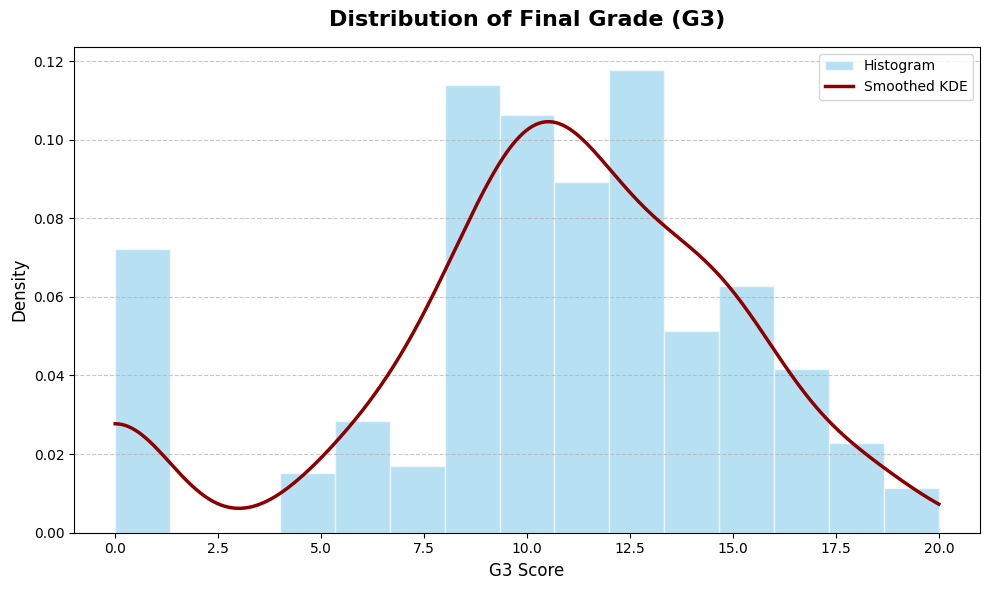


📊 Summary Statistics for G3 (Final Grade):

- Mean:                  10.42
- Median:                11.0
- Mode(s):               10
- Standard Deviation:    4.58
- Min:                   0
- Max:                   20

📐 Distribution Shape:
- Skewness:              -0.730  (Left-skewed)
- Kurtosis:              +0.383  (Leptokurtic)

📈 Percentiles:
- 10th               5.0
- 25th (Q1)          8.0
- 50th (Median)      11.0
- 75th (Q3)          14.0
- 90th               15.600000000000023

📊 Performance Breakdown:
- Above average:         209 students
- Below average:         186 students
- Failing (≤ 9):      130
- Perfect score (20):    1

🚨 Outliers detected:     0 student(s) using IQR method


In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# ╔════════════════════════════════════════════════════════════╗
# ║                     🎨 G3 HISTOGRAM PLOT                   ║
# ╚════════════════════════════════════════════════════════════╝

# Extract G3 column
g3 = df["G3"]

plt.figure(figsize=(10, 6))  # Wider plot

# Plot histogram
counts, bins, patches = plt.hist(
    g3, bins=15, density=True, edgecolor='white', color='skyblue', alpha=0.6, label="Histogram"
)

# Add KDE curve
kde = stats.gaussian_kde(g3)
x = np.linspace(g3.min(), g3.max(), 500)
plt.plot(x, kde(x), color='darkred', linewidth=2.5, label="Smoothed KDE")

# Titles and labels
plt.title("Distribution of Final Grade (G3)", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("G3 Score", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Grid & ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Legend
plt.legend()

# Tight layout for spacing
plt.tight_layout()
plt.show()

# ╔════════════════════════════════════════════════════════════╗
# ║         📊 STATISTICAL SUMMARY OF G3 DISTRIBUTION          ║
# ╚════════════════════════════════════════════════════════════╝

# Basic stats
mean = g3.mean()
median = g3.median()
mode = g3.mode().values
std = g3.std()
min_val = g3.min()
max_val = g3.max()

# Distribution shape
skewness = stats.skew(g3)
kurtosis = stats.kurtosis(g3)

# Percentiles
percentiles = {
    "10th": np.percentile(g3, 10),
    "25th (Q1)": np.percentile(g3, 25),
    "50th (Median)": np.percentile(g3, 50),
    "75th (Q3)": np.percentile(g3, 75),
    "90th": np.percentile(g3, 90),
}

# Counts relative to mean
above_avg = (g3 > mean).sum()
below_avg = (g3 < mean).sum()

# Thresholds
fail_threshold = 9
perfect_score = 20
num_failing = (g3 <= fail_threshold).sum()
num_perfect = (g3 == perfect_score).sum()

# Outlier detection using IQR
Q1 = percentiles["25th (Q1)"]
Q3 = percentiles["75th (Q3)"]
IQR = Q3 - Q1
outliers = g3[(g3 < (Q1 - 1.5 * IQR)) | (g3 > (Q3 + 1.5 * IQR))]

# Display everything
print("\n📊 Summary Statistics for G3 (Final Grade):\n")
print(f"- Mean:                  {mean:.2f}")
print(f"- Median:                {median}")
print(f"- Mode(s):               {', '.join(map(str, mode))}")
print(f"- Standard Deviation:    {std:.2f}")
print(f"- Min:                   {min_val}")
print(f"- Max:                   {max_val}")

print("\n📐 Distribution Shape:")
print(f"- Skewness:              {skewness:+.3f}  ({'Right-skewed' if skewness > 0 else 'Left-skewed' if skewness < 0 else 'Symmetrical'})")
print(f"- Kurtosis:              {kurtosis:+.3f}  ({'Leptokurtic' if kurtosis > 0 else 'Platykurtic' if kurtosis < 0 else 'Mesokurtic'})")

print("\n📈 Percentiles:")
for label, value in percentiles.items():
    print(f"- {label:<18} {value}")

print("\n📊 Performance Breakdown:")
print(f"- Above average:         {above_avg} students")
print(f"- Below average:         {below_avg} students")
print(f"- Failing (≤ {fail_threshold}):      {num_failing}")
print(f"- Perfect score ({perfect_score}):    {num_perfect}")

print(f"\n🚨 Outliers detected:     {len(outliers)} student(s) using IQR method")